# Portfolio Analysis: 6-Month Comparison

## Traditional vs Crypto-Enhanced Portfolios

This notebook analyzes the performance of two portfolios over a 6-month period:
1. **Traditional Portfolio**: Stocks and Bonds only
2. **Crypto-Enhanced Portfolio**: Stocks, Bonds, and Cryptocurrencies

### Objectives
- Compare risk and return metrics
- Analyze diversification benefits
- Visualize performance and correlations

In [1]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import DataLoader
from preprocessing import calculate_returns, handle_missing_values
from metrics import portfolio_metrics, correlation_matrix

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Processed Data

Load the data prepared by the Prefect workflow.

In [2]:
# Load processed data
data_path = '../data/processed/processed_portfolio_data.parquet'
df = pd.read_parquet(data_path)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Data shape: (213, 70)
Date range: 2023-06-01 00:00:00 to 2023-12-30 00:00:00

Columns: [('GOOGL', 'Open'), ('GOOGL', 'High'), ('GOOGL', 'Low'), ('GOOGL', 'Close'), ('GOOGL', 'Volume'), ('AMZN', 'Open'), ('AMZN', 'High'), ('AMZN', 'Low'), ('AMZN', 'Close'), ('AMZN', 'Volume'), ('TSLA', 'Open'), ('TSLA', 'High'), ('TSLA', 'Low'), ('TSLA', 'Close'), ('TSLA', 'Volume'), ('AAPL', 'Open'), ('AAPL', 'High'), ('AAPL', 'Low'), ('AAPL', 'Close'), ('AAPL', 'Volume'), ('MSFT', 'Open'), ('MSFT', 'High'), ('MSFT', 'Low'), ('MSFT', 'Close'), ('MSFT', 'Volume'), ('JPM', 'Open'), ('JPM', 'High'), ('JPM', 'Low'), ('JPM', 'Close'), ('JPM', 'Volume'), ('JNJ', 'Open'), ('JNJ', 'High'), ('JNJ', 'Low'), ('JNJ', 'Close'), ('JNJ', 'Volume'), ('BNB-USD', 'Open'), ('BNB-USD', 'High'), ('BNB-USD', 'Low'), ('BNB-USD', 'Close'), ('BNB-USD', 'Volume'), ('SOL-USD', 'Open'), ('SOL-USD', 'High'), ('SOL-USD', 'Low'), ('SOL-USD', 'Close'), ('SOL-USD', 'Volume'), ('ETH-USD', 'Open'), ('ETH-USD', 'High'), ('ETH-USD', 'Low'

Ticker           GOOGL                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2023-06-01  121.978707  123.567745  121.780080  122.872543  30772700.0   
2023-06-02  123.140690  125.285898  122.912270  123.816032  26980100.0   
2023-06-03  123.140690  125.285898  122.912270  123.816032  26980100.0   
2023-06-04  123.140690  125.285898  122.912270  123.816032  26980100.0   
2023-06-05  123.160550  126.557122  122.991709  125.146851  32305500.0   

Ticker            AMZN                                                  ...  \
Price             Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2023-06-01  120.690002  123.489998  119.930000  122.769997  54375100.0  ...   
2023-06-02  124.919998  126.389999  124.019997  124.250000  61264400.0  ...   
2023-06-03  124.919998  126.389999  124.019997  124.250000  61264400.0  ...   
2023-06-04  124.919998  126.389999  124.019997  124.250000  61264400.0  ...   
2023-06-05  123.360001  125.800003  123.029999  125.300003  47950100.0  ...   

Ticker            AGG                                                    TLT  \
Price            Open       High        Low      Close     Volume       Open   
Date                                                                           
2023-06-01  89.909314  90.091690  89.799895  89.918434  9029800.0  93.327141   
2023-06-02  89.854608  89.891083  89.435154  89.444267  6877200.0  93.074116   
2023-06-03  89.854608  89.891083  89.435154  89.444267  6877200.0  93.074116   
2023-06-04  89.854608  89.891083  89.435154  89.444267  6877200.0  93.074116   
2023-06-05  89.225442  89.654017  89.152492  89.435173  7246200.0  91.583123   

Ticker                                                   
Price            High        Low      Close      Volume  
Date                                                     
2023-06-01  93.643411  92.739779  93.182564  21040400.0  
2023-06-02  93.137370  92.116268  92.161446  19136500.0  
2023-06-03  93.137370  92.116268  92.161446  19136500.0  
2023-06-04  93.137370  92.116268  92.161446  19136500.0  
2023-06-05  92.568085  91.456615  91.989761  14433200.0  

[5 rows x 70 columns]

## 2. Extract Close Prices

Extract closing prices for each asset.

In [3]:
# Extract close prices (adjust based on actual column structure)
# Assuming MultiIndex columns from yfinance: (ticker, 'Close')

# Get all 'Close' columns
close_prices = df.xs('Close', level=1, axis=1)

print(f"Close prices shape: {close_prices.shape}")
close_prices.head()

Close prices shape: (213, 14)


Ticker,GOOGL,AMZN,TSLA,AAPL,MSFT,JPM,JNJ,BNB-USD,SOL-USD,ETH-USD,BTC-USD,SPY,AGG,TLT
Date,,,,,,,,,,,,,,
2023-06-01,122.872543,122.769997,207.520004,177.930130,326.339447,129.730972,143.154236,304.953278,20.502218,1862.201416,26819.972656,408.231201,89.918434,93.182564
2023-06-02,123.816032,124.250000,213.970001,178.779831,329.106537,132.456100,145.405228,307.423798,21.257595,1907.256592,27249.589844,414.134766,89.444267,92.161446
2023-06-03,123.816032,124.250000,213.970001,178.779831,329.106537,132.456100,145.405228,306.720123,21.155565,1892.412476,27075.128906,414.134766,89.444267,92.161446
2023-06-04,123.816032,124.250000,213.970001,178.779831,329.106537,132.456100,145.405228,305.156799,21.818975,1890.513550,27119.066406,414.134766,89.444267,92.161446
2023-06-05,125.146851,125.300003,217.610001,177.426270,329.636353,131.154846,146.655762,276.889252,20.075060,1811.828369,25760.097656,413.341125,89.435173,91.989761


## 3. Calculate Returns

In [4]:
# Calculate log returns
returns = calculate_returns(close_prices, method='log')

print(f"Returns shape: {returns.shape}")
returns.head()

Returns shape: (212, 14)


Ticker,GOOGL,AMZN,TSLA,AAPL,MSFT,JPM,JNJ,BNB-USD,SOL-USD,ETH-USD,BTC-USD,SPY,AGG,TLT
Date,,,,,,,,,,,,,,
2023-06-02,0.007649,0.011983,0.030608,0.004764,0.008443,0.020788,0.015602,0.008069,0.036181,0.023907,0.015892,0.014358,-0.005287,-0.011019
2023-06-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002292,-0.004811,-0.007813,-0.006423,0.000000,0.000000,0.000000
2023-06-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005110,0.030877,-0.001004,0.001621,0.000000,0.000000,0.000000
2023-06-05,0.010691,0.008415,0.016869,-0.007600,0.001609,-0.009873,0.008564,-0.097208,-0.083302,-0.042512,-0.051410,-0.001918,-0.000102,-0.001865
2023-06-06,0.010264,0.010401,0.016860,-0.002062,-0.006750,0.001796,-0.000885,0.016499,0.015982,0.039323,0.055815,0.002175,0.001223,0.005876


## 4. Define Portfolios

Define asset allocations for traditional and crypto-enhanced portfolios.

In [5]:
# Identify asset types
stocks = [col for col in returns.columns if col not in ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'AGG', 'TLT', 'SPY']]
bonds = ['AGG', 'TLT', 'SPY']  # Bond ETFs and market index
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD']

# Filter available assets
stocks = [s for s in stocks if s in returns.columns]
bonds = [b for b in bonds if b in returns.columns]
cryptos = [c for c in cryptos if c in returns.columns]

print(f"Stocks: {stocks}")
print(f"Bonds: {bonds}")
print(f"Cryptos: {cryptos}")

# Portfolio 1: Traditional (60% stocks, 40% bonds)
traditional_assets = stocks + bonds
traditional_weights = np.array([0.6/len(stocks)] * len(stocks) + [0.4/len(bonds)] * len(bonds))

# Portfolio 2: Crypto-Enhanced (50% stocks, 30% bonds, 20% crypto)
crypto_enhanced_assets = stocks + bonds + cryptos
crypto_weights = np.array(
    [0.5/len(stocks)] * len(stocks) + 
    [0.3/len(bonds)] * len(bonds) + 
    [0.2/len(cryptos)] * len(cryptos)
)

print(f"\nTraditional portfolio: {len(traditional_assets)} assets")
print(f"Crypto-enhanced portfolio: {len(crypto_enhanced_assets)} assets")

Stocks: ['GOOGL', 'AMZN', 'TSLA', 'AAPL', 'MSFT', 'JPM', 'JNJ']
Bonds: ['AGG', 'TLT', 'SPY']
Cryptos: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD']

Traditional portfolio: 10 assets
Crypto-enhanced portfolio: 14 assets


## 5. Calculate Portfolio Returns

In [6]:
# Calculate portfolio returns
traditional_returns = (returns[traditional_assets] * traditional_weights).sum(axis=1)
crypto_returns = (returns[crypto_enhanced_assets] * crypto_weights).sum(axis=1)

# Combine for comparison
portfolio_returns = pd.DataFrame({
    'Traditional': traditional_returns,
    'Crypto-Enhanced': crypto_returns
})

portfolio_returns.head()

,Traditional,Crypto-Enhanced
Date,,
2023-06-02,0.008298,0.011139
2023-06-03,0.000000,-0.001067
2023-06-04,0.000000,0.001319
2023-06-05,0.001940,-0.012062
2023-06-06,0.003776,0.009424


## 6. Performance Metrics

In [7]:
# Calculate metrics for both portfolios
traditional_metrics = portfolio_metrics(traditional_returns)
crypto_metrics = portfolio_metrics(crypto_returns)

# Create comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Traditional': traditional_metrics,
    'Crypto-Enhanced': crypto_metrics
})

# Display numeric metrics only
numeric_metrics = metrics_comparison.select_dtypes(include=[np.number])
print("\n" + "="*60)
print("PORTFOLIO PERFORMANCE COMPARISON")
print("="*60)
print(numeric_metrics.to_string())
print("="*60)


PORTFOLIO PERFORMANCE COMPARISON
Empty DataFrame
Columns: []
Index: [Annualized Return, Annualized Volatility, Sharpe Ratio, Sortino Ratio, Max Drawdown, Drawdown Start, Drawdown End, VaR (95%), CVaR (95%), Total Return, Best Day, Worst Day]


## 7. Cumulative Returns Visualization

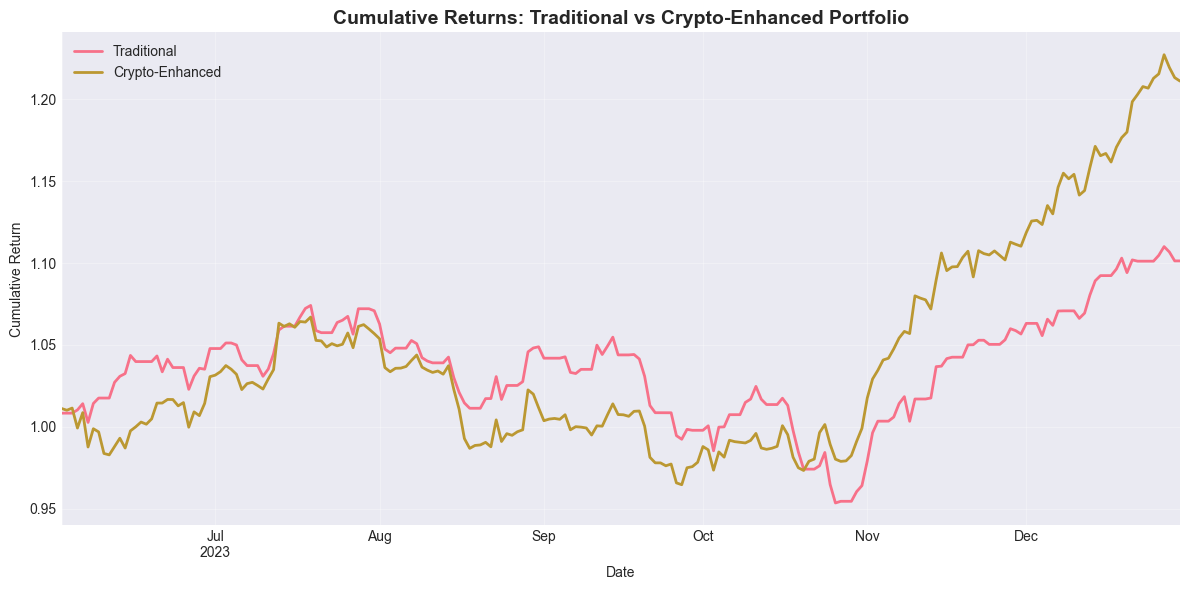

In [8]:
# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
cumulative_returns.plot(ax=ax, linewidth=2)
ax.set_title('Cumulative Returns: Traditional vs Crypto-Enhanced Portfolio', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Risk-Return Scatter Plot

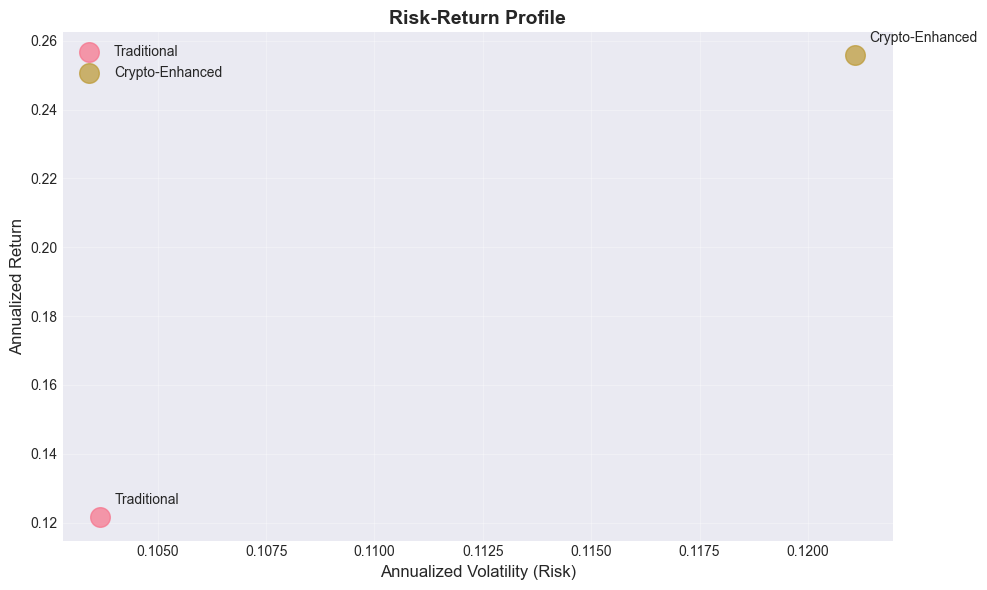

In [9]:
# Extract annualized return and volatility
portfolios_data = [
    ('Traditional', traditional_metrics['Annualized Return'], traditional_metrics['Annualized Volatility']),
    ('Crypto-Enhanced', crypto_metrics['Annualized Return'], crypto_metrics['Annualized Volatility'])
]

fig, ax = plt.subplots(figsize=(10, 6))
for name, ret, vol in portfolios_data:
    ax.scatter(vol, ret, s=200, alpha=0.7, label=name)
    ax.annotate(name, (vol, ret), xytext=(10, 10), textcoords='offset points')

ax.set_xlabel('Annualized Volatility (Risk)', fontsize=12)
ax.set_ylabel('Annualized Return', fontsize=12)
ax.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Correlation Analysis

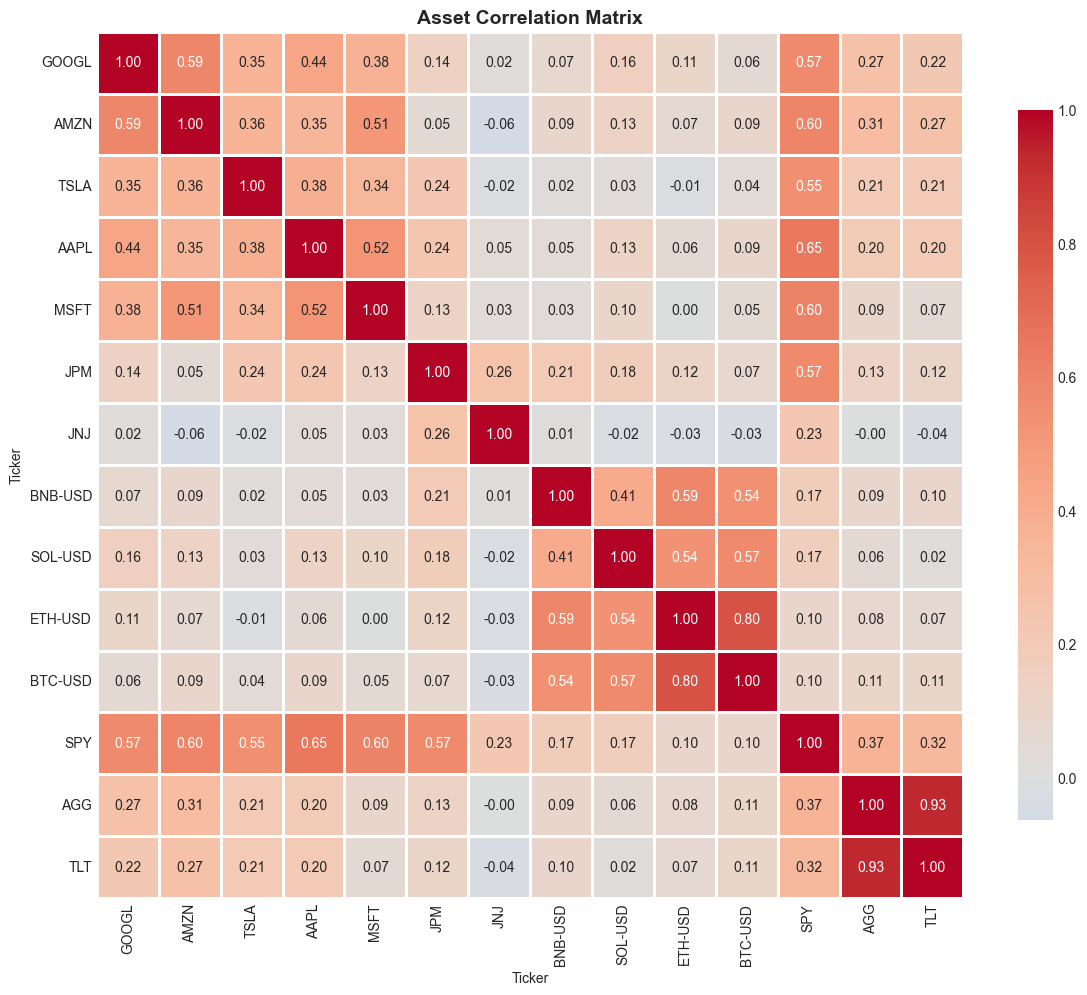

In [10]:
# Calculate correlation matrix
corr_matrix = correlation_matrix(returns)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Asset Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Drawdown Analysis

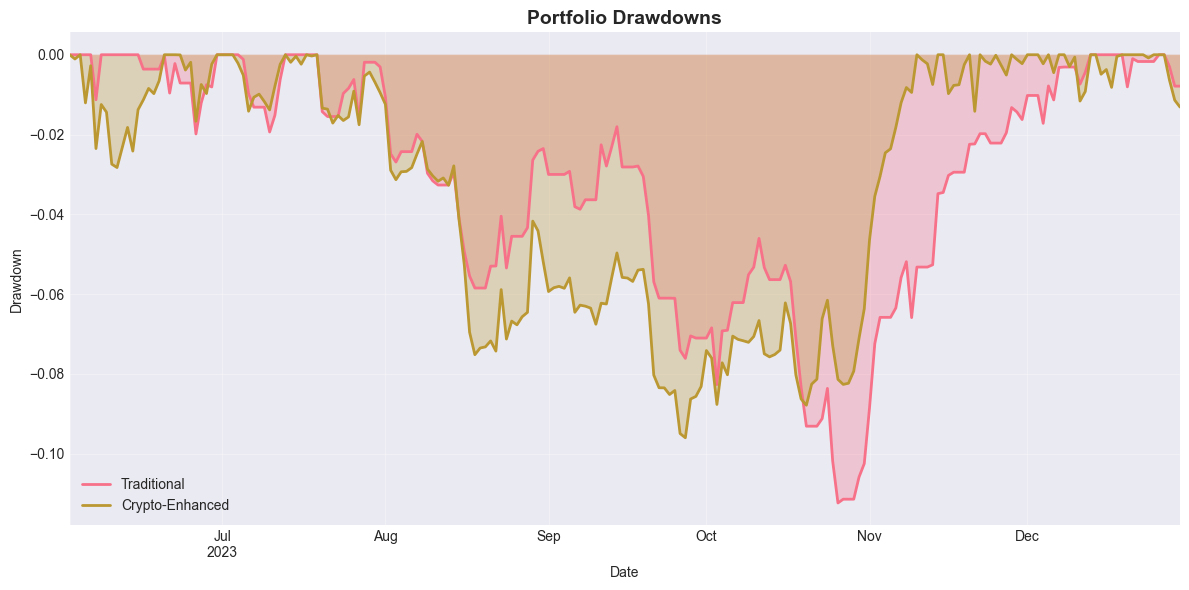

In [11]:
# Calculate drawdowns
def calculate_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown

traditional_dd = calculate_drawdown(traditional_returns)
crypto_dd = calculate_drawdown(crypto_returns)

drawdowns = pd.DataFrame({
    'Traditional': traditional_dd,
    'Crypto-Enhanced': crypto_dd
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
drawdowns.plot(ax=ax, linewidth=2)
ax.fill_between(drawdowns.index, drawdowns['Traditional'], 0, alpha=0.3)
ax.fill_between(drawdowns.index, drawdowns['Crypto-Enhanced'], 0, alpha=0.3)
ax.set_title('Portfolio Drawdowns', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Summary and Conclusions

### Key Findings:

1. **Returns**: Compare the annualized returns of both portfolios
2. **Risk**: Analyze volatility and maximum drawdown
3. **Risk-Adjusted Performance**: Compare Sharpe and Sortino ratios
4. **Diversification**: Examine correlation benefits from crypto inclusion

### Next Steps:

- Extend analysis to 1 year, 2 years, 5 years, and 10 years
- Implement portfolio optimization (Markowitz, Black-Litterman)
- Add predictive models (ARIMA, GARCH, ML)
- Conduct scenario analysis and stress testing

In [12]:
# Save results
metrics_comparison.to_csv('../data/processed/portfolio_metrics_6months.csv')
print("✓ Results saved to data/processed/portfolio_metrics_6months.csv")

✓ Results saved to data/processed/portfolio_metrics_6months.csv
